In [1]:
# -*- coding: utf8 -*-


from sirsaia import brasilio
from sirsaia import epiestim
from sirsaia import plotutils

import glob
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [2]:
plt.ion()
plt.style.use('seaborn-colorblind')
plt.rcParams['figure.figsize']  = (12, 8)

/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


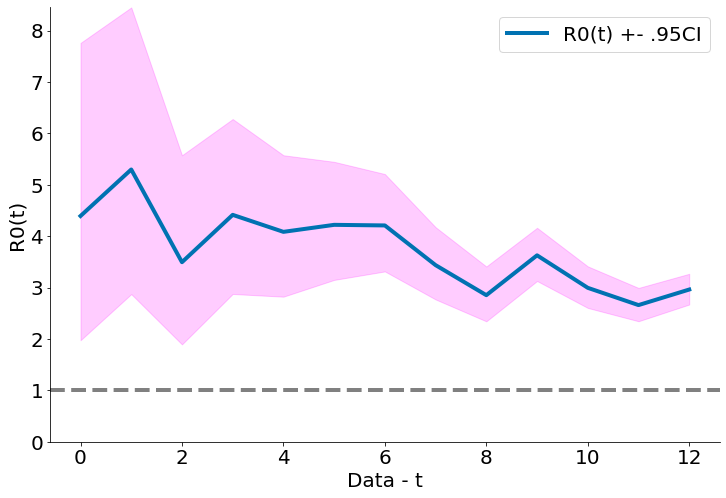

In [3]:
df_orig = pd.read_excel('./data/COVID-19-geographic-disbtribution-worldwide-2020-03-28.xlsx')
df_br = df_orig[df_orig['countriesAndTerritories'] == 'Brazil']
who_df = df_br[['cases']].copy()
who_df.columns = ['local']
who_df.index = pd.to_datetime(df_br['dateRep'])
who_df = who_df.sort_index().fillna(0)
first_day = np.nonzero(who_df.values)[0][0]
who_df = who_df[first_day:]
who_df = who_df[:'2020-03-19']

epiestim_result = epiestim.estimate_r(who_df)
plotutils.plot_result(epiestim_result)

In [4]:
datasets = {}
sheets = glob.glob('data/covid19/[A-Z]*/*.xlsx')
for sheet in sorted(sheets):
    state = os.path.basename(sheet)[:2]
    region = os.path.basename(os.path.dirname(sheet))
    if region not in datasets:
        datasets[region] = {}
    datasets[region][state] = sheet

In [9]:
for region in datasets:
    for state, fpath in datasets[region].items():
        df = brasilio.load_data(fpath)
        model_df = df[['TOTAL NO ESTADO', 'Importados/Indefinidos']].copy()
        model_df.columns = ['local', 'imported']
        epiestim_result = epiestim.estimate_r(model_df)
        plotutils.plot_result(epiestim_result, model_df)
        plt.title(state + ' last mean = {}'.format(epiestim_result['Mean(R)'].values[-1]))
        try:
            os.makedirs('plots/{}/'.format(region))
        except:
            pass
        plt.tight_layout()
        plt.savefig('plots/{}/{}.png'.format(region, state))
        plt.close()

Ignoring imported column, all zeros


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


Ignoring imported column, all zeros


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


Ignoring imported column, all zeros


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To ch

Ignoring imported column, all zeros


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


Ignoring imported column, all zeros


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


KeyboardInterrupt: 

/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


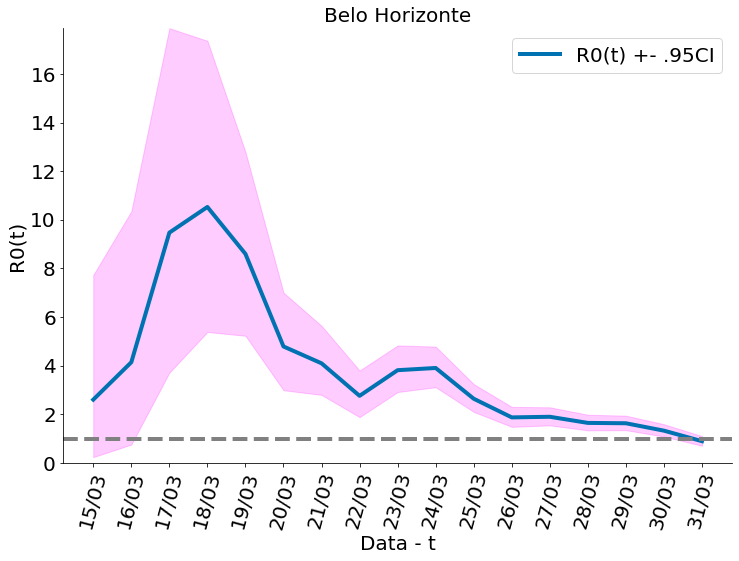

In [6]:
df = brasilio.load_data('data/covid19/Sudeste/MG.xlsx')
model_df = df[['Belo Horizonte']].copy()
model_df.columns = ['local']
plt.title('Belo Horizonte')
epiestim_result = epiestim.estimate_r(model_df)
plotutils.plot_result(epiestim_result, model_df)